In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from lib.util.helper import query_table
from validation.gp.create_train_inference import create_train_inference_gp
from lib.util import helper, data_preprocessing
import torch
from torch.utils.data import TensorDataset, DataLoader
import gpytorch
import seaborn as sns
import torch
import gpytorch

In [49]:
df = query_table(table='main_terminal_1H')

In [50]:
df['kw'] = round(df['kw'], 2)
df['kw'] = df['kw'].apply(lambda x: 0.0 if x == -0.0 else x)

## Experiment # 1
### Train = 2 production weeks ; Test = next production week ; Agg = 30T

In [51]:
168 / 24

7.0

In [52]:
#df = query_table(table='vacuum_pump_1_30T')
#df['kw'] = round(df['kw'], 2)
#df['kw'] = df['kw'].apply(lambda x: 0.0 if x == -0.0 else x)
df = df[(df.index >= '2017-10-01') & (df.index < '2017-12-02')]
print(df.shape)

time_int_range = np.arange(0, df.shape[0]*60, 60)
df['t'] = time_int_range
df['t'] = (df['t'] - df['t'].min()) / (df['t'].max() - df['t'].min())

training = df[df.index < '2017-11-27']
testing = df[df.index >= '2017-11-27']

X_train = torch.from_numpy(training['t'].values).to(torch.float32)
y_train = torch.from_numpy(training['kw'].values).to(torch.float32)

X_test = torch.from_numpy(df['t'].values).to(torch.float32)
X_test_sub = torch.from_numpy(testing['t'].values).to(torch.float32)
y_test = torch.from_numpy(testing['kw'].values).to(torch.float32)

# Standardizing helps with hyperparameter initialization
y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)

y_train = (y_train - y_train_mean) / (y_train_std)
y_test = (y_test - y_train_mean) / (y_train_std)

(1488, 1)


In [53]:
## v1 - end loss = 0.71##

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        period_constraint_short = gpytorch.constraints.Interval(0.00453, 0.00634) ## 12hr periodicity

        half_day_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_short
                )
            )

        half_day_variation_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RQKernel()
        )

        quasi_half_day_kernel = half_day_kernel * half_day_variation_kernel

        period_constraint_short_2 = gpytorch.constraints.Interval(0.00951, 0.01223) ## 24hr periodicity

        day_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_short_2
                )
            )
        
        day_variation_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RQKernel()
        )

        quasi_day_kernel = day_kernel * day_variation_kernel

        # ---

        period_constraint_short_3 = gpytorch.constraints.Interval(0.07385, 0.07838) ## weekly periodicity

        day_kernel_long = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_short_3
                )
            )
        
        day_long_variation_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RQKernel()
        )

        quasi_day_kernel_long = day_kernel_long * day_long_variation_kernel

        # ---


        ## Local Variations ##
        local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)
        
        local_variation = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RQKernel()
            )
            
        local_variation.alpha = local_variation_alpha.mean

        self.covar_module = quasi_half_day_kernel + quasi_day_kernel + quasi_day_kernel_long
        #self.covar_module = local_variation
        self.mean_module = gpytorch.means.ZeroMean()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [54]:
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 65

#model.double()
#likelihood.double()

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood=likelihood, model=model)

loss_iter = {}
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, y_train)
    loss.backward()

    print('Iter {} , Loss = {} , Noise = {}'.format(
        i+1, loss, model.likelihood.noise.item() 
    ))
    loss_iter[i] = loss.detach().numpy()

    optimizer.step()

model.eval()
likelihood.eval()

Iter 1 , Loss = 1.4662193059921265 , Noise = 0.6932471990585327
Iter 2 , Loss = 1.447919487953186 , Noise = 0.7444966435432434
Iter 3 , Loss = 1.4313217401504517 , Noise = 0.7967433929443359
Iter 4 , Loss = 1.4262735843658447 , Noise = 0.8484128713607788
Iter 5 , Loss = 1.4171524047851562 , Noise = 0.8977776765823364
Iter 6 , Loss = 1.411145806312561 , Noise = 0.9424740076065063
Iter 7 , Loss = 1.4109489917755127 , Noise = 0.9803244471549988
Iter 8 , Loss = 1.412563681602478 , Noise = 1.0099595785140991
Iter 9 , Loss = 1.4108378887176514 , Noise = 1.0308282375335693
Iter 10 , Loss = 1.4109008312225342 , Noise = 1.042945146560669
Iter 11 , Loss = 1.4117558002471924 , Noise = 1.0469176769256592
Iter 12 , Loss = 1.4055440425872803 , Noise = 1.0438005924224854
Iter 13 , Loss = 1.4033104181289673 , Noise = 1.034635066986084
Iter 14 , Loss = 1.4005621671676636 , Noise = 1.0205879211425781
Iter 15 , Loss = 1.3967727422714233 , Noise = 1.0028810501098633
Iter 16 , Loss = 1.3993403911590576 , N

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

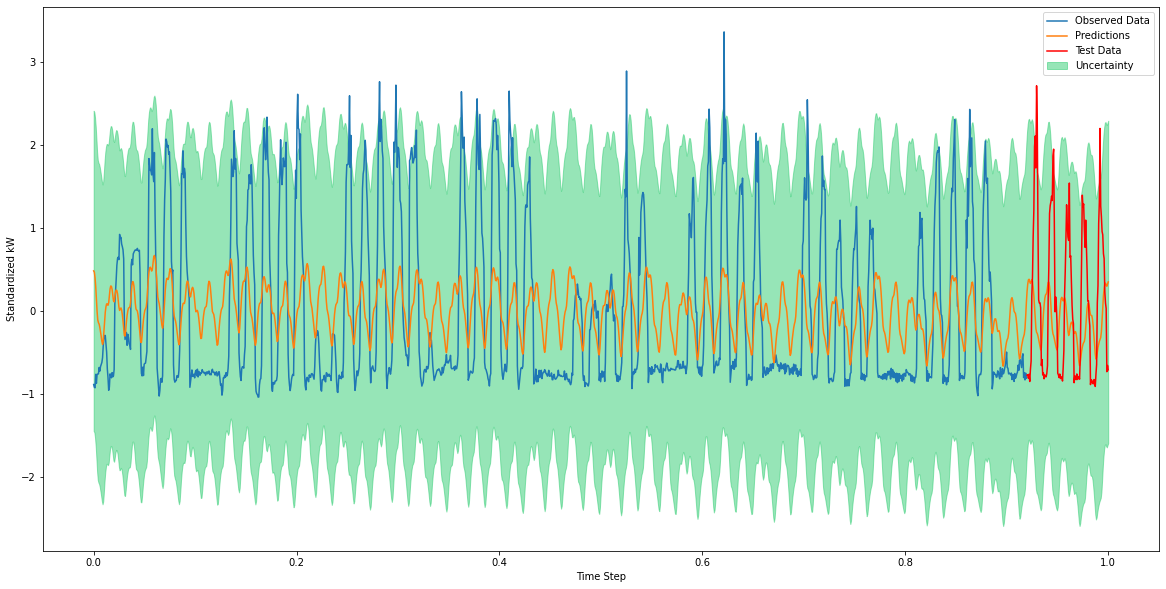

In [46]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_preds = likelihood(model(X_test))

    #test_preds = observed_preds.mean[n_train:]
    #mse = mean_squared_error(y_test.numpy(), test_preds.numpy())
    #mape = mean_absolute_percentage_error(y_test.numpy(), test_preds.numpy())

    f, ax = plt.subplots(figsize=(20, 10))
    lower, upper = observed_preds.confidence_region()
    ax.plot(X_train.numpy(), y_train.numpy())
    ax.plot(X_test.numpy(), observed_preds.mean.numpy())
    ax.plot(X_test_sub.numpy(), y_test.numpy(), color='red')
    ax.fill_between(X_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, color='#2ecc71')
    #plt.axvline(x=955, linestyle='--', color='black', lw=1)
    ax.legend(['Observed Data', 'Predictions', 'Test Data', 'Uncertainty'])
    plt.xlabel('Time Step')
    plt.ylabel('Standardized kW')
    #plt.title('Gaussian Process Regression: Interpolation and Extrapolation of "EG" \n  MSE = {} \n MAPE = {}'.
    #format(round(mse, 2), round(mape, 2)))
    plt.show()

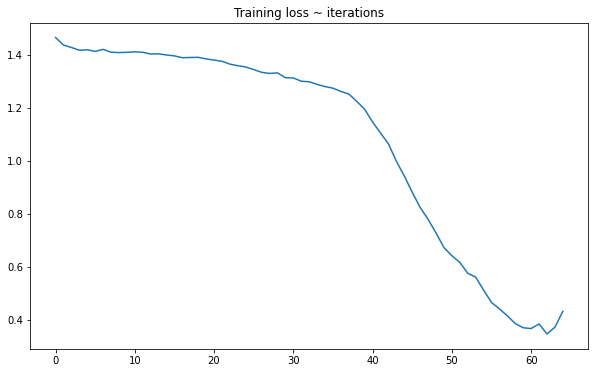

In [9]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=np.array(list(loss_iter.keys())).flatten(), y=np.array(list(loss_iter.values())).flatten())
plt.title('Training loss ~ iterations')
plt.show()